# Аналитика в сервисе по продаже билетов <a name="content"></a>

# Оглавление

* [Описание проекта](#project_description)
* [Описание данных](#data_description)
* [Шаг 1. Изучение и предобработка входных данных](#step_1)
    * [1.1. Изучение входных данных](#step_1_1)
    * [1.2. Подготовка данных к анализу](#step_1_2)
    * [Шаг 1. Вывод](#step_1_end)
* [Шаг 2. Продукт. Расчёт метрик](#step_2)
    * [2.1. Оценка пользовательской активности (dau, wau, mau)](#step_2_1)
    * [2.3. Пользовательская сессия. Продолжительность сессии](step_2_2)
    * [2.3. Пользовательская сессия. Количество сессий в день](#step_2_3)
    * [2.3. Retention Rare и Churn Rate. Как часто люди возвращаются?](#step_2_4)
    * [Шаг 2. Вывод (продукт)](#step_2_end)
* [Шаг 3. Продажи. Расчёт метрик](#step_3)
    * [3.1. Когда пользователи начинают покупать?](#step_3_1)
    * [3.2. Количество покупок за период](#step_3_2)
    * [3.3. Средний чек](#step_3_3)
    * [3.4. Количество приносмых денег (LTV)](#step_3_4)
    * [Шаг 3. Вывод (продажи)](#step_3_end)
* [Шаг 4. Маркетинг. Расчёт метрик](#step_4)
    * [4.1. Расчёт метрик CAC и ROI](#step_4_1)
    * [4.2. Сколько денег потратили](#step_4_2)
* [Шаг 5. Рекомендации маркетологам](#step_5)
* [Шаг 6. Общий вывод](#step_6)

# Описание проекта <a name="project_description"></a>

Необходимо оптимизировать маркетинговые затраты в **сервисе по продаже билетов**.

В распоряжении есть данные от сервиса с июня 2017 по конец мая 2018 года:

* лог сервера с данными о посещениях сайта сервиса,


* выгрузка всех заказов за этот период,


* статистика рекламных расходов.

[**Вернуться к оглавлению...**](#content)

# Описание данных <a name="data_description"></a>

Таблица **visits** (лог сервера с информацией о посещениях сайта):

* **Uid** — уникальный идентификатор пользователя;


* **Device** — категория устройства пользователя;


* **Start Ts** — дата и время начала сессии;


* **End Ts** — дата и время окончания сессии;


* **Source Id** — идентификатор рекламного источника, из которого пришел пользователь.

Таблица **orders** (информация о заказах):

* **Uid** — уникальный id пользователя, который сделал заказ;


* **Buy Ts** — дата и время заказа;


* **Revenue** — выручка Яндекс.Афиши с этого заказа.

Таблица costs (информация о затратах на маркетинг):

* **source_id** — идентификатор рекламного источника;


* **dt** — дата;


* **costs** — затраты на этот рекламный источник в этот день;

[**Вернуться к оглавлению...**](#content)

# Шаг 1. Изучение  и предобработка входных данных <a name="step_1"></a>

## 1.1. Изучение вдходных данных <a name="step_1_1"></a>

Импорт библиотек, необходимых для решения поставленной задачи.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
from matplotlib import pyplot as plt

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Чтение файлов с входными данными.

In [3]:
visits = pd.read_csv('../project_datasets/visits_log.csv')
orders = pd.read_csv('../project_datasets/orders_log.csv')
costs = pd.read_csv('../project_datasets/costs.csv')

Получим общую информацию о датафрейме `visits`.

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Получим общую информацию о датафрейме `orders`.

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [7]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Получим общую информацию о датафрейме `costs`.

In [8]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [9]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


[**Вернуться к оглавлению...**](#content)

## 1.2. Подготовка данных к анализу <a name="step_1_2"></a>

In [10]:
for data in [visits, orders, costs]:
    data.columns = data.columns.str.replace(' ', '_').str.lower()

In [11]:
costs = costs.rename(columns = {'dt': 'date'})
orders = orders.rename(columns = {'buy_ts': 'order_date'})

In [12]:
def to_datetime_format(series):
    if series.name == 'date':
        datetime_format = '%Y-%m-%d'
    else:
        datetime_format = '%Y-%m-%d %H:%M:%S'
    series = pd.to_datetime(series, format = datetime_format)
    return series

In [13]:
costs['date'] = to_datetime_format(costs['date'])
visits['end_ts'] = to_datetime_format(visits['end_ts'])
visits['start_ts'] = to_datetime_format(visits['start_ts'])
orders['order_date'] = to_datetime_format(visits['end_ts'])

Изучим строки, в которых дата и время начала сессии больше, чем дата и время окончания сессии.

In [14]:
visits[visits['start_ts'] > visits['end_ts']]

,device,end_ts,source_id,start_ts,uid
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453


Таких строк оказалось всего 2. Посмотрим, какой процент от общего числа данных они составляют.

In [15]:
print('{:.5%}'.format(len(visits[visits['start_ts'] > visits['end_ts']]) / len(visits)))

0.00056%


Процент найденных значений оказался равен меньше 0.01%, что позволяет нам просто избавиться от данной аномалии.

Далее посмотрим, присутствуют ли строки, в которых дата и время начала и окончания сессии полностью равны.

In [16]:
visits[visits['start_ts'] == visits['end_ts']].head()

,device,end_ts,source_id,start_ts,uid
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
28,desktop,2017-11-09 15:53:00,4,2017-11-09 15:53:00,17892541477379911957
32,desktop,2017-11-30 12:29:00,4,2017-11-30 12:29:00,13410401624913285510
54,desktop,2018-02-23 16:52:00,10,2018-02-23 16:52:00,13423278602430425332


In [17]:
print('{:.5%}'.format(len(visits[visits['start_ts'] == visits['end_ts']]) / len(visits)))

9.95938%


Процент строк с полным совпадением даты и времени равен почти 10%. Эти данные могут говорить нам о том, что у пользователя не получилось воспользоваться сервисом, но попытка входа была зарегистрирована. Это может быть связано, к примеру, с тем, что у пользователя в момент входа пропало интернет-соединение. Мы сохраним эти данные, но нем будем учитывать их при расчётах продолжительность пользовательской сессии.

Перезапишем данные датафрейма `visits`.

In [18]:
visits = visits[visits['start_ts'] <= visits['end_ts']].copy()

Изучим значения параметра `revenue` датафрейма `orders`.

In [19]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

Результат работы метода `describe()` показал, что в параметре присутствуют нулевые значения. Значения с нулевой выручкой могут говорить нам, как минимум, о двух возможных вариантах образования этих данных. 

По-моему мнению, это могут быть либо какие-то акционные заказы или заказы с применением промокода, не принесшие выручку, либо это баг. При расчёте необходимых метрик эти данные могу исказить результаты, поэтому их необходимо удалить.

Посчитаем какой процент составляют данные с нулевой выручкой.

In [20]:
print('{:.2%}'.format(len(orders[orders['revenue'] == 0]) / len(orders)))

0.10%


Данные, от которых мы хотели избавяться составляют 0.1%. Перезапишем датафрейм `orders`, в который будут включены только те, покупки в которых выручка сервиса больше 0.

In [21]:
orders = orders[orders['revenue'] > 0].copy()

[**Вернуться к оглавлению...**](#content)

## Шаг 1. Вывод <a name="step_1_end"></a>

**1.1. Изучение входных данных:**

* Датасеты `visits.csv`, `orders.csv`, `costs.csv` были прочитаны при помощи метода `read_csv()`.


* Пропущенные значения, в исследуемых датафреймах `visits`, `orders`, `costs`, не были обнаружены.



* Типы данных во всех датафреймах были проверены на соответствие. В результате проверки было обнаружено, что некоторые параметры, хранящие в себе информацию о датах имели тип данных `object`. 



* В наименованиях некоторых параметров были обнаружены пробелы.

**1.2. Подготовка данных к анализу:**

В ходе предобробатки в данных были проивзедены следующие изменения:

* Пробелы в наименованиях параметров были заменены на нижнее подчёркивание `_`.


* Наименования параметров были приведены к нижнему регистру.


* Наименование параметра `dt` датафрейма `costs` было изменено на `date`.



* Параметры `ens_ts` и `start_ts` датафрейма `visits`, параметр `buy_ts` датафрейма `orders` и параметр `date` датафрейма `costs` были приведены к типу данных `datetime64`.


* В датафрейме `visits` были удалены аномалии, где время дата и время начала сесии были больше даты и времени её окончания.


* Из датафрейма `orders` были удалены строки в которых значения параметра `revenue` были равны нулю.

[**Вернуться к оглавлению...**](#content)

# Шаг 2. Продукт. Расчёт метрик <a name="step_2"></a>

## 2.1. Оценка пользовательской активности (dau, wau, mau) <a name="step_2_1"></a>

Для того чтобы ответить на вопрос, **какое количество людей пользуются сервисом в день/неделю/месяц** необходимо произвести расчёт **vanity metrics** (англ. *«метрики тщеславия»*). В их число входят такие метрики как:

* **DAU** (от англ. *daily active users*) — количество уникальных пользователей в день;


* **WAU** (от англ. *weekly active users*) — количество уникальных пользователей в неделю;


* **MAU** (от англ. *monthly active users*) — количество уникальных пользователей в месяц.

При расчётах необходимо учитывать именнно уникальных пользователей. Их количество будет показателем того, что продуктом интересуются не только те, кто с ним уже знаком.

Для расчёта вышеупомянутых метрик, выделим в отдельные столбцы год, месяц, неделю, а также полную дату.

In [22]:
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

Посмотрим, какие категории устройств присутствуют в датафрейме `visits`.

In [23]:
visits['device'].unique()

array(['touch', 'desktop'], dtype=object)

Создадим функцию, которая будет группировать датафрейм, принимаемый на вход по заданному, в качестве второго аргумента функции, параметру.

In [24]:
def generate_pivot(data, metric_type):
    return (data
            .groupby(['session_year', ('session_' + str(metric_type))])
            .agg({'uid': 'nunique'})
            .reset_index()
            .rename(columns = {'uid': 'amount_unique_user'}))

Сгруппируем данные по дню, неделе и месяцу использования, расчитав при этом количество уникальных пользователей для каждой категории устройств.

Расчёт метрики **dau** общей и для каждой категории устройств.

In [25]:
dau_total = generate_pivot(visits, 'date')
dau_touch = generate_pivot(
    visits[visits['device'] == 'touch'], 'date')
dau_desktop = generate_pivot(
    visits[visits['device'] == 'desktop'], 'date')

Расчёт метрики **wau** общей и для каждой категории устройств.

In [26]:
wau_total = generate_pivot(visits, 'week')
wau_touch = generate_pivot(
    visits[visits['device'] == 'touch'], 'week')
wau_desktop = generate_pivot(
    visits[visits['device'] == 'desktop'], 'week')

Создадим функцию `year_of_week`, которая будет для каждой недели в параметре `session_week` добавлять маркер года.

In [27]:
def year_of_week(data):
    if data['session_year'] == 2017:
        return data['session_week'].astype('str') + ' (2017)'
    elif data['session_year'] == 2018:
        return data['session_week'].astype('str') + ' (2018)'

Применим функцию `year_of_week` ко всем датафрейма с расчётом метрики **wau**.

In [28]:
wau_total['session_week'] = wau_total.apply(year_of_week, axis = 1)
wau_touch['session_week'] = wau_touch.apply(year_of_week, axis = 1)
wau_desktop['session_week'] = wau_desktop.apply(year_of_week, axis = 1)

Расчёт метрики **mau** общей и для каждой категории устройств.

In [29]:
mau_total = generate_pivot(visits, 'month')
mau_touch = generate_pivot(visits[visits['device'] == 'touch'], 'month')
mau_desktop = generate_pivot(visits[visits['device'] == 'desktop'], 'month')

Для каждого датафрейма с расчётом **mau** переведём параметр `session_month` к типу данных `str`.

In [30]:
mau_total['session_month'] = mau_total['session_month'].dt.to_period('M').astype('str')
mau_touch['session_month'] = mau_touch['session_month'].dt.to_period('M').astype('str')
mau_desktop['session_month'] = mau_desktop['session_month'].dt.to_period('M').astype('str')

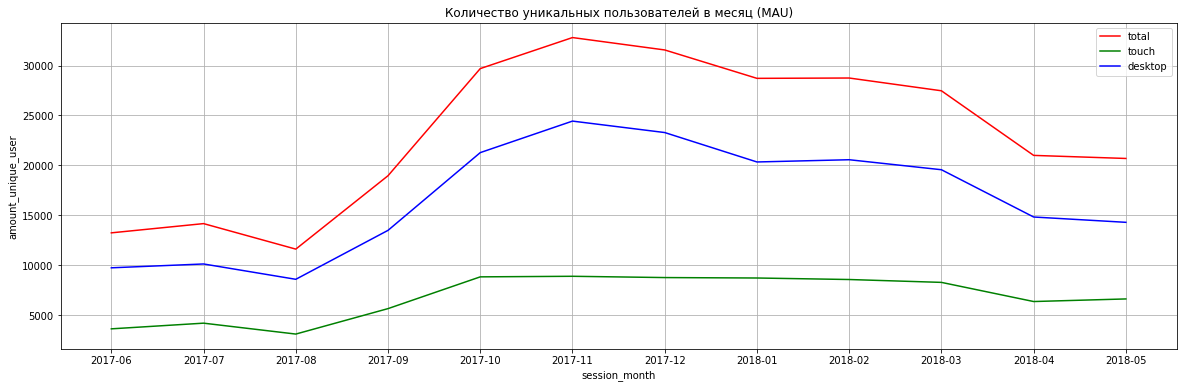

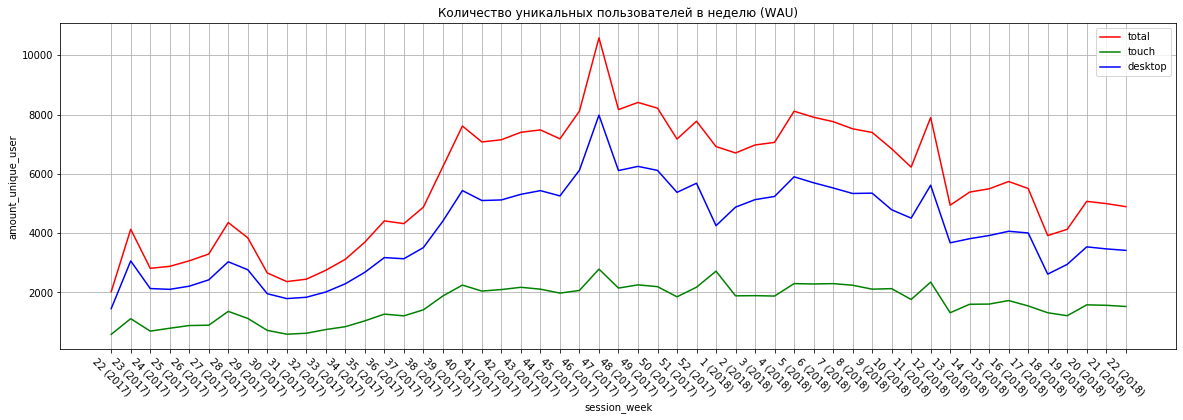

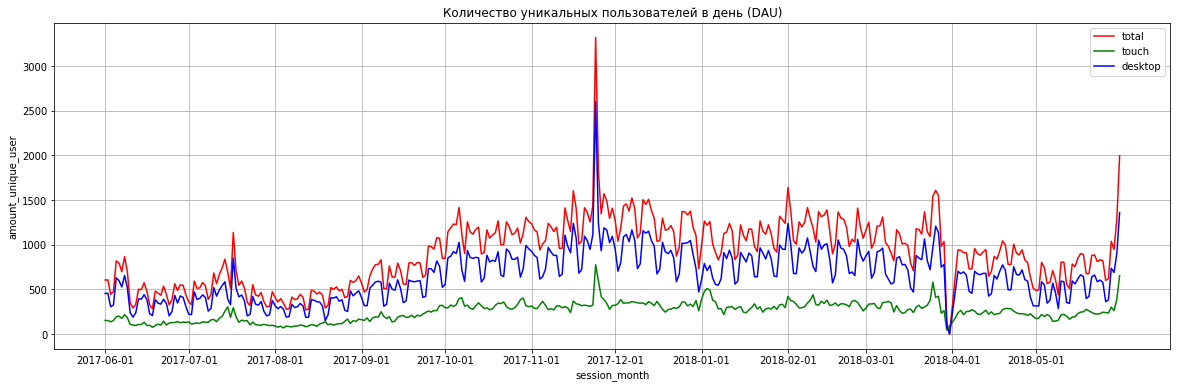

In [31]:
plt.figure(figsize = (20, 6))
plt.grid()
ax = plt.plot(mau_total['session_month'], mau_total['amount_unique_user'], color = 'red')
ax1 = plt.plot(mau_touch['session_month'], mau_touch['amount_unique_user'], color = 'green')
plt.plot(mau_desktop['session_month'], mau_desktop['amount_unique_user'], color = 'blue')
plt.title('Количество уникальных пользователей в месяц (MAU)')
plt.legend(['total', 'touch', 'desktop'])
plt.xlabel('session_month')
plt.ylabel('amount_unique_user')
plt.xticks(rotation = 0)
plt.show()

plt.figure(figsize = (20, 6))
plt.grid()
ax = plt.plot(wau_total['session_week'], wau_total['amount_unique_user'], color = 'red')
ax1 = plt.plot(wau_touch['session_week'], wau_touch['amount_unique_user'], color = 'green')
plt.plot(wau_desktop['session_week'], wau_desktop['amount_unique_user'], color = 'blue')
plt.title('Количество уникальных пользователей в неделю (WAU)')
plt.legend(['total', 'touch', 'desktop'])
plt.xlabel('session_week')
plt.ylabel('amount_unique_user')
plt.xticks(rotation = 315)
plt.show()

plt.figure(figsize = (20, 6))
plt.grid()
ax = plt.plot(dau_total['session_date'], dau_total['amount_unique_user'], color = 'red')
ax1 = plt.plot(dau_touch['session_date'], dau_touch['amount_unique_user'], color = 'green')
plt.plot(dau_desktop['session_date'], dau_desktop['amount_unique_user'], color = 'blue')
plt.title('Количество уникальных пользователей в день (DAU)')
plt.legend(['total', 'touch', 'desktop'])
plt.xlabel('session_month')
plt.ylabel('amount_unique_user')
plt.xticks(mau_total['session_month'].values, rotation = 0)
plt.show()

Исходя из увиденного на графике, можно сделать вывод, что в среднем пользователи, использующие для входа категорию устройств `desktop` заходят на сайт в большем количестчем, чем те пользователи, которые используют для входа категорию устройств `touch`.

На графике **dau** наблюдаются два аномальных значения. Посмотрим, в какой точно день произошёл такой резкий наплыв пользователей.

In [32]:
dau_total[dau_total['amount_unique_user'] > 1900]

,session_year,session_date,amount_unique_user
176,2017,2017-11-24,3319
363,2018,2018-05-31,1997


Итак, два всплеска приходятся на 24 ноября 2017 и 31 мая 2018. Возможно, в этот на сервисе проводилась акция или розыгрыш билетов.

**Расчёт средних значений метрик.**

Посчитаем метрики, путём нахождения среднего количества пользователей.

In [33]:
dau_mean = int(dau_total['amount_unique_user'].mean())
wau_mean = int(wau_total['amount_unique_user'].mean())
mau_mean = int(mau_total['amount_unique_user'].mean())

Выведем на экран значения, которым равны искомые метрики.

In [34]:
print('''
dau: {}
wau: {}
mau: {}
'''.format(dau_mean, wau_mean, mau_mean))


dau: 907
wau: 5716
mau: 23228



Ещё одна метрика - **sticky factor** (англ. *«липкий фактор»*). Расчёт этой метрики производят для определения регулярности использования сервиса.

In [35]:
sticky_wau = (dau_mean / wau_mean) * 100
sticky_mau = (dau_mean / mau_mean) * 100

In [36]:
print('''
sticky_wau: {:.2f}
sticky_mau: {:.2f}
'''.format(sticky_wau, sticky_mau))


sticky_wau: 15.87
sticky_mau: 3.90



[**Вернуться к оглавлению...**](#content)

## 2.2. Пользовательская сессия. Продолжительность сессии <a name="step_2_3"></a>

Далее определим среднюю продолжительность пользовательской сессии. Эта метрика называется **ASL** (англ. *average session length*).

Посчитаем продолжительность сессиий для каждого визита.

In [37]:
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

В датафрейме `visits_with_duration` выделим сессии с ненулевой длительность.

In [38]:
visits_with_duration = visits[visits['duration'] > 0].copy()

Мы знаем, что существуют две категории устройств, с помощью которых пользователи посещают сайт. Выделим эти две категории в отдельные датафреймы.

In [39]:
visits_touch = visits_with_duration[
    visits_with_duration['device'] == 'touch'].copy()
visits_desktop = visits_with_duration[
    visits_with_duration['device'] == 'desktop'].copy()

Для того чтобы правильно определить меру центральной тенденции для продолжительности пользовательской сессии, взглянем на её распределение.

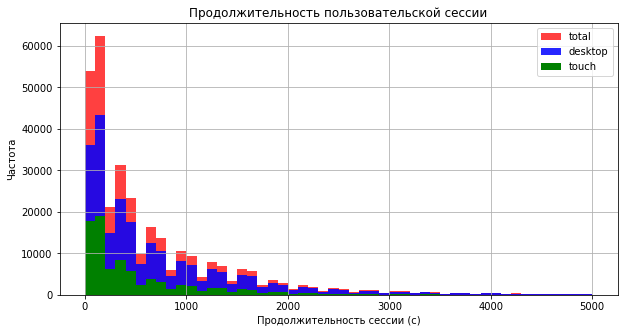

In [40]:
plt.figure(figsize = (10, 5))
plt.grid()
ax = plt.hist(visits_with_duration['duration'],
              color = 'red', bins = 50, range = (0, 5000), alpha = 0.75)
ax1 = plt.hist(visits_desktop['duration'],
               color = 'blue', bins = 50, range = (0, 5000), alpha = 0.85)
plt.hist(visits_touch['duration'],
         color = 'green', bins = 50, range = (0, 5000))
plt.title('Продолжительность пользовательской сессии')
plt.legend(['total', 'desktop', 'touch'])
plt.xlabel('Продолжительность сессии (с)')
plt.ylabel('Частота')
plt.show()

Данное распредедение далеко от нормального, поэтому в качестве меры центральной тенденции лучше использовать значение, которое в данной выборке встречается чаще всего.

In [41]:
asl_total = int(visits_with_duration['duration'].mode())
asl_touch = int(visits_touch['duration'].mode())
asl_desktop = int(visits_desktop['duration'].mode())

In [42]:
print('''
Средняя продолжительность сессии total: {} (c)
Средняя продолжительность сессии touch: {} (c)
Средняя продолжительность сессии desktop: {} (c)
'''.format(asl_total, asl_touch, asl_desktop))


Средняя продолжительность сессии total: 60 (c)
Средняя продолжительность сессии touch: 60 (c)
Средняя продолжительность сессии desktop: 60 (c)



Мы видим, что при сравнении моды продолжительности для двух типов устройств получается одинаковый результат. В таком случае необходимо проверить, существует ли статистическое различие между средними двух генеральных совокупностей.

Проверим, существует ли статистически значимое различие между средним временем посещений при использовании пользователями двух различных категорий устройств.

<b>Формулировка нулевой гипотезы H<sub>0</sub>:</b> Средние продолжительности пользовательских сессий для категорий устройств `desktop` и `touch` **равны**.

<b>Формулировка альтернативной гипотезы H<sub>1</sub>:</b> Средние продолжительности пользовательских сессий для категорий устройств `desktop` и `touch` **не равны**.

In [43]:
visits_touch_duration = visits_touch['duration']
visits_desktop_duration = visits_desktop['duration']

In [44]:
alpha = 0.05
results = st.ttest_ind(visits_touch_duration,
                       visits_desktop_duration, equal_var = False)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу!")
else:
    print("Не получилось отвергнуть нулевую гипотезу!")

Отвергаем нулевую гипотезу!


Нулевая гипотеза отвергнута, следовательно, средние продолжительности сессий на разных категориях устройств, **не равны**.

[**Вернуться к оглавлению...**](#content)

## 2.3. Пользовательская сессия. Количество сессий в день <a name="step_2_2"></a>

Определим, насколько регулярно пользователи используют приложение. Для этого необходимо разделить количество сессий на количество пользователей, к примеру, за день.

Для начала построим сводную таблицу `sessions_per_user`, где для каждого месяца каждого года найдём количество сессий и количество уникальных пользователей.

In [45]:
sessions_per_user = (
    visits
    .groupby(['session_year', 'session_month'])
    .agg({'uid': ['count','nunique']}))

Переименуем параметры таблицы `sessions_per_user`.

In [46]:
sessions_per_user.columns = ['n_sessions', 'n_users']

Определим, сколько сессий приходится на одного пользователя в месяц.

In [47]:
sessions_per_user['sessions_per_user'] = \
sessions_per_user['n_sessions'] / sessions_per_user['n_users']

In [48]:
sessions_per_user = sessions_per_user.reset_index()

Выведем таблицу `sessions_per_user` на экран.

In [49]:
sessions_per_user

,session_year,session_month,n_sessions,n_users,sessions_per_user
0,2017,2017-06-01,16505,13259,1.244815
1,2017,2017-07-01,17828,14183,1.256998
2,2017,2017-08-01,14355,11631,1.234202
3,2017,2017-09-01,23907,18975,1.259921
4,2017,2017-10-01,37903,29692,1.276539
5,2017,2017-11-01,43969,32797,1.340641
6,2017,2017-12-01,41983,31557,1.330386
7,2018,2018-01-01,36939,28716,1.286356
8,2018,2018-02-01,37182,28749,1.293332
9,2018,2018-03-01,35677,27473,1.298620


Посчитаем среднее количество сессий, приходящееся на одного пользователя в месяц.

In [50]:
print('{:.2f}'.format(sessions_per_user['sessions_per_user'].mean()))

1.28


В месяц один пользователь в среднем проводит в приложении максимум 1 сессию. Не сказать, что продукт используется регулярно.

Аналогичным образом расчитаем среднее количество сессий, приходящееся на одного пользователя в день.

In [51]:
sessions_per_day = (
    visits
    .groupby(['session_year', 'session_date'])
    .agg({'uid': ['count', 'nunique']}))

In [52]:
sessions_per_day.columns = ['n_sessions', 'n_users']

In [53]:
sessions_per_day['sessions_per_day'] = \
sessions_per_day['n_sessions'] / sessions_per_day['n_users']

In [54]:
sessions_per_day = sessions_per_day.reset_index()

In [55]:
sessions_per_day.head()

,session_year,session_date,n_sessions,n_users,sessions_per_day
0,2017,2017-06-01,664,605,1.097521
1,2017,2017-06-02,658,608,1.082237
2,2017,2017-06-03,477,445,1.071910
3,2017,2017-06-04,510,476,1.071429
4,2017,2017-06-05,893,820,1.089024


In [56]:
print('{:.2f}'.format(sessions_per_day['sessions_per_day'].mean()))

1.08


В среднем на одного пользователя в день приходится не более 1 сессии.

[**Вернуться к оглавлению...**](#content)

# 2.4. Retention Rate и Churn Rate. Как часто люди возвращаются? <a name="step_2_4"></a>

Создадим датафрейм `user_activity`, включив в него два параметра из датафрейма `visits`.

In [57]:
user_activity = visits[['uid', 'start_ts']].copy()
user_activity.columns = ['user_id', 'activity_date']

Выделим из параметра `activity_date` только дату.

In [58]:
user_activity['activity_date'] = pd.to_datetime(
    user_activity['activity_date'].dt.date, format = '%Y-%m-%d')

Сгруппируем данные по параметру `user_id` и найдём первую дату посещения сервиса для каждого пользователя.

In [59]:
first_activity_date = (
    user_activity
    .groupby(['user_id'])['activity_date'].min()
    .reset_index())

first_activity_date = (
    first_activity_date
    .rename(columns = {'activity_date': 'first_activity_date'}))

In [60]:
first_activity_date.head()

,user_id,first_activity_date
0,11863502262781,2018-03-01
1,49537067089222,2018-02-06
2,297729379853735,2017-06-07
3,313578113262317,2017-09-18
4,325320750514679,2017-09-30


Соеденими датафреймы `user_activity` и `first_activity_date` по параметру `user_id`.

In [61]:
user_activity = user_activity.merge(
    first_activity_date, how = 'left', on = 'user_id')

Выделим из даты активности и даты первой активности месяца для корректного расчёта времени жизни когорты.

In [62]:
user_activity['activity_month'] = (
    user_activity['activity_date'].astype('datetime64[M]'))

In [63]:
user_activity['first_activity_month'] = (
    user_activity['first_activity_date'].astype('datetime64[M]'))

Далее в таблицу `user_activity` добавим параметр, который будет хранить в себе время жизни когорты в месяцах.

In [64]:
user_activity['cohort_lifetime'] = (
    (user_activity['activity_month'] - 
     user_activity['first_activity_month']) / 
    np.timedelta64(1,'M')).round().astype('int64')

Выведем первые 5 строк таблицы `user_activity`, чтобы оценить результат проделанной работы.

In [65]:
user_activity.head()

,user_id,activity_date,first_activity_date,activity_month,first_activity_month,cohort_lifetime
0,16879256277535980062,2017-12-20,2017-12-20,2017-12-01,2017-12-01,0
1,104060357244891740,2018-02-19,2018-02-19,2018-02-01,2018-02-01,0
2,7459035603376831527,2017-07-01,2017-07-01,2017-07-01,2017-07-01,0
3,16174680259334210214,2018-05-20,2018-03-09,2018-05-01,2018-03-01,2
4,9969694820036681168,2017-12-27,2017-12-27,2017-12-01,2017-12-01,0


Сгруппируем данные по когорте и **lifetime**. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни». Результат сохраним в переменной `cohorts`.

In [66]:
cohorts = (user_activity
           .groupby(['first_activity_month', 'cohort_lifetime'])
           .agg({'user_id': 'nunique'}).reset_index())

Найдём исходное количество пользователей в когорте. Возьмём их число на нулевой месяц. Данные сохраним в переменной `initial_users_count`.

In [67]:
initial_users_count = (
    cohorts[cohorts['cohort_lifetime'] == 0]
    [['first_activity_month','user_id']].reset_index(drop = True))

initial_users_count = \
initial_users_count.rename(columns = {'user_id' : 'cohort_users'})

Выведем `initial_users_count` на экран.

In [68]:
initial_users_count

,first_activity_month,cohort_users
0,2017-06-01,13259
1,2017-07-01,13140
2,2017-08-01,10181
3,2017-09-01,16704
4,2017-10-01,25977
5,2017-11-01,27248
6,2017-12-01,25268
7,2018-01-01,22624
8,2018-02-01,22197
9,2018-03-01,20589


Объединим данные по когортам с исходным количеством пользователей в когорте.

In [69]:
cohorts = cohorts.merge(
    initial_users_count, how = 'left', on = 'first_activity_month')

Наконец, рассчитаем **Retention Rate**. Разделим количество активных пользователей в каждый из месяцев на исходное число пользователей в когорте.

In [70]:
cohorts['retention'] = cohorts['user_id'] / cohorts['cohort_users']

Оставим в данных о месяце первого заказа только месяц и год.

In [71]:
cohorts['first_activity_month'] = (
    cohorts['first_activity_month'].dt.to_period('M'))

In [72]:
cohorts.head()

,first_activity_month,cohort_lifetime,user_id,cohort_users,retention
0,2017-06,0,13259,13259,1.000000
1,2017-06,1,1043,13259,0.078664
2,2017-06,2,713,13259,0.053775
3,2017-06,3,814,13259,0.061392
4,2017-06,4,909,13259,0.068557


Создадим функцию, которая будет строить тепловую карту для переданной ей, в качестве аргумента, таблицы.

Создадим сводную таблицу с расчётом **retantion rate** для построения тепловой карты.

In [73]:
rr_table = cohorts.pivot_table(
    index = 'first_activity_month',
    columns = 'cohort_lifetime',
    values = 'retention',
    aggfunc = 'sum')

Построим тепловую карту **retantion rate**.

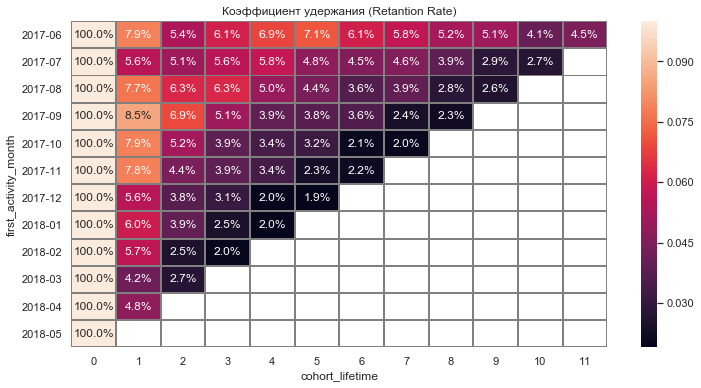

In [74]:
yticks = rr_table.index
sns.set(style = 'white')
plt.figure(figsize = (12, 6))
sns.heatmap(rr_table, annot = True, fmt = '.1%', linewidths = 1,
            yticklabels = yticks, linecolor = 'gray', vmax = 0.1)
plt.title('Коэффициент удержания (Retantion Rate)')
plt.yticks(rotation = 0)
plt.show()

Определим на сколько пользователей в когорте становиться меньше в сравнении с предыдущим периодом, расчитав метрику **churn rate**.

In [75]:
cohorts['churn_rate'] = (
    cohorts.groupby(['first_activity_month'])['user_id'].pct_change())

Построим сводную таблицу и выведем на экран тепловую карту.

In [76]:
cr_table = cohorts.pivot_table(
    index = 'first_activity_month',
    columns = 'cohort_lifetime',
    values = 'churn_rate',
    aggfunc = 'sum')

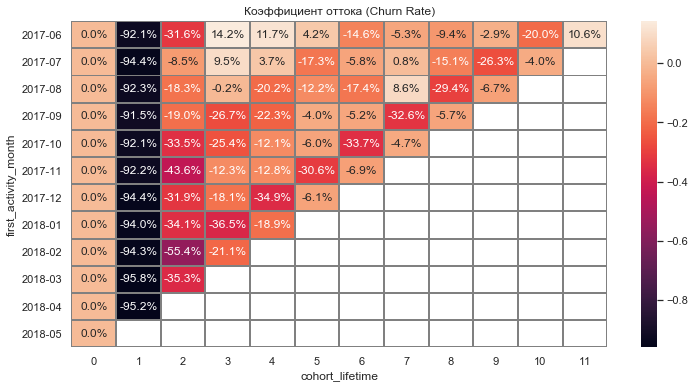

In [77]:
yticks = cr_table.index
sns.set(style = 'white')
plt.figure(figsize = (12, 6))
sns.heatmap(cr_table, annot = True, fmt = '.1%', linewidths = 1,
            yticklabels = yticks, linecolor = 'gray')
plt.title('Коэффициент оттока (Churn Rate)')
plt.yticks(rotation = 0)
plt.show()

Данные, отображённые на тепловых картах, говорят нам о том, что на второй месяц жизни каждая когорта теряет более 90% пользователей.

[**Вернуться к оглавлению...**](#content)

## Шаг 2. Вывод (продукт) <a name="step_2_end"></a>

**1.** Для продукта была проведена оценка пользовательской активности. В результате были посчитаны следующие метрики:
    
 
* **DAU** = 907;
    
 
* **WAU** = 5716;
    
 
* **MAU** = 23228;
    

* **Sticky factor (WAU)** = 15.87;
    
 
* **Sticky factor (MAU)** = 3.90
   
Кроме того, был построен графики, сравнивающие метрики **dau**, **wau**, **mau** на двух разных типах устройств. График показал, что пользователей, использующих тип устройства `desktop` ежедневно/еженедельно/ежемесячно приходит больше, чем пользователей, использующих `touch`.

Также стоит отметить, что на графике **dau** присутствуют два аномальных значения по количеству пришеддших пользователей. Два аномальных паплыва приходятся на 24 ноября 2017 и 31 мая 2018. Возможно, в этот на сервисе проводилась акция или розыгрыш билетов.

**2.** Пользовательская сессия


* Следующим шагом в изучения продукта была оценка пользовательской сессии. Первым делом был произведён подсчёт количества сессий в месяц и в день, в среднем приходящееся на одного пользователя. Результаты расчёта равны **1.28 сессий на одного пользователя**. Это значит, что пользователи не посещают сервис более одного раза в месяц. 


* Средняя продолжительность сессии **ASL** равна **1-й минуте**. Кроме того, продолжительности пользовательских сессий на разных типах устройств имеют статистические различия. Пользователи, использующие тип устройств `desktop` в среднем проводят больше времени за сессию. Можно сделать предположение, что сайт или приложение в мобильной версии отображаются некорректно или имеют прочие технические ошибки. Стоит это проверить.

**3.** Retantion Rate и Churn Rate. Были построеные две тепловые карты для вышеупомянутых метрик. Тепловая карта метрики Churn Rate показала, что большой отток пользователей происходит на 2 месяце жизни когорты. Возможно, на этом этапе у пользователей возникают сложности с взаимодействием с продуктом или они уходят по каким-то другим причинам. 

[**Вернуться к оглавлению...**](#content)

# Шаг 3. Продажи. Расчёт метрик <a name="step_3"></a>

## 3.1. Когда пользователи начинают покупать? <a name="step_3_1"></a>

Далее определим, спустя какое время после своего первого визита на сайт пользователи начинают совершать покупки.

Для начала преобразуем датафрейм `visits` в исходный вид, чтобы параметры, задействованные на предыдуших шагах не мешали.

In [78]:
visits = visits[['device', 'end_ts', 'source_id', 'start_ts', 'uid']].copy()

Далее определим для каждого пользователя дату и время его первого визита, а после дату и время первой покупки. Полученные результаты сохраним в датафреймах `first_visit` и `first_order` соответсвенно. Далее объединим эти таблицы, создав единый датафрейм `order_visit_diff`, включив в него только тех пользователей, который когда-либо совершали покупку на сайте.

In [79]:
first_visit = (visits.groupby('uid')['start_ts'].min()
               .reset_index().rename(columns = {'start_ts':'first_visit_date'}))

first_order = (orders.groupby('uid')['order_date'].min()
               .reset_index().rename(columns = {'order_date':'first_order_date'}))

order_visit_diff = first_order.merge(first_visit, how = 'left', on = 'uid')

Выделим из даты первого визита месяц. Это необходимо для дальнейшей группировки пользователей по соответствующим когортам.

In [80]:
order_visit_diff['first_visit_month'] = order_visit_diff['first_visit_date'].astype('datetime64[M]')
order_visit_diff['first_visit_month'] = order_visit_diff['first_visit_month'].dt.to_period('M')

Найдём разницу в секундах между первым посещением сайта и первой покупкой для каждого пользователя. Результат сохраним в параметр `diff_in_seconds`.

In [81]:
order_visit_diff['diff_in_seconds'] = \
(order_visit_diff['first_order_date'] - order_visit_diff['first_visit_date']).dt.seconds

Далее сгруппируем данные таблицы `order_visit_diff` по месяцу первого посещения и определим, сколько в среднем прошло времмени перед тем как пользователи, впервые посетившие сайт в соответстующий месяц, совершили свою первую покупку.

In [82]:
diff_pivot = (order_visit_diff.groupby('first_visit_month')['diff_in_seconds']
              .mean().reset_index().rename(columns = {'diff_in_seconds':'diff_in_seconds_mean'}))

Переведём полученный результат средней продолжительности из секунд в часы.

In [83]:
diff_pivot['diff_in_hours_mean'] = (diff_pivot['diff_in_seconds_mean'] // 3600).round().astype('int64')

In [84]:
diff_pivot['first_visit_month'] = diff_pivot['first_visit_month'].dt.strftime('%Y-%m')

Выведем, полученную сводную таблицу на экран.

In [85]:
diff_pivot

,first_visit_month,diff_in_seconds_mean,diff_in_hours_mean
0,2017-06,43135.462012,11
1,2017-07,42249.597070,11
2,2017-08,41795.525857,11
3,2017-09,42454.229637,11
4,2017-10,42288.251389,11
5,2017-11,43377.393754,12
6,2017-12,43023.199017,11
7,2018-01,43635.177942,12
8,2018-02,42474.387947,11
9,2018-03,42308.372093,11


Построим график зависимости среднего времени до первой покупки от месяца покупки.

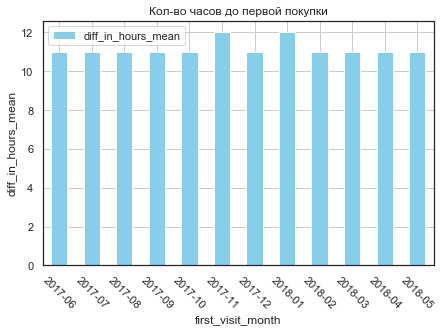

In [86]:
diff_pivot.plot(x = 'first_visit_month',
                y = 'diff_in_hours_mean', kind = 'bar',
                color = 'skyblue', grid = True, figsize = (7, 4.5))

plt.title('Кол-во часов до первой покупки')
plt.ylabel('diff_in_hours_mean')
plt.xticks(rotation = 315)
plt.show()

Итак, на графике мы видим, что с течением времени пользователи, впервые посетившие сайт в разные месяцы указанного периода, начинают приходить к моменту совершения первой покупки быстрее.

[**Вернуться к оглавлению...**](#content)

## 3.2. Количество покупок за период <a name="step_3_2"></a>

In [87]:
orders_upd = orders[orders['order_date'] < '2018-06-01'].copy()
orders_upd['order_month'] = orders_upd['order_date'].astype('datetime64[M]').dt.strftime('%Y-%m')

Посчитаем количество покупок для каждого месяца, исследуемого временного интервала.

In [88]:
orders_amount = (orders_upd.groupby('order_month').agg({'uid': 'count'})
                 .reset_index().rename(columns = {'uid': 'orders_amount'}))

Отобразим полученный результат на графике.

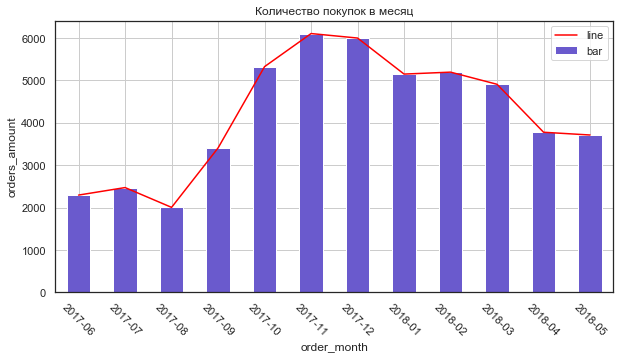

In [89]:
ax = orders_amount.plot(x = 'order_month', y = 'orders_amount', 
                   color = 'red', grid = True, figsize = (10, 5))

orders_amount.plot(x = 'order_month', y = 'orders_amount', kind = 'bar', 
                   color = 'slateblue', grid = True, figsize = (10, 5), ax = ax)

plt.title('Количество покупок в месяц')
plt.legend(['line', 'bar'])
plt.ylabel('orders_amount')
plt.xticks(rotation = 315)
plt.show()

По графику можно сделать вывод, что общее количество покупок возрастает в ноябре и декабре. Вероятно, в предверии новогодних праздников. И показатель общего количества покупко в первые месяцы 2018 года в среднем выше, чем в конце 2017. Этот факт говорит о положительной динамике.

[**Вернуться к оглавлению...**](#content)

## 3.3. Средний чек <a name="step_3_3"></a>

Создадим сводную таблицу `avg_check`, чтобы определить как изменяется средний в чек зависимости от месяца исследуемого периода.

In [90]:
avg_check = (orders_upd.groupby('order_month')['revenue'].mean()
             .reset_index().rename(columns = {'revenue': 'avg_check'}))

In [91]:
avg_check

,order_month,avg_check
0,2017-06,4.540915
1,2017-07,4.763243
2,2017-08,6.075165
3,2017-09,4.772424
4,2017-10,4.886517
5,2017-11,4.723464
6,2017-12,4.820650
7,2018-01,4.979955
8,2018-02,5.770743
9,2018-03,5.108890


Построим график изменения среднего чека.

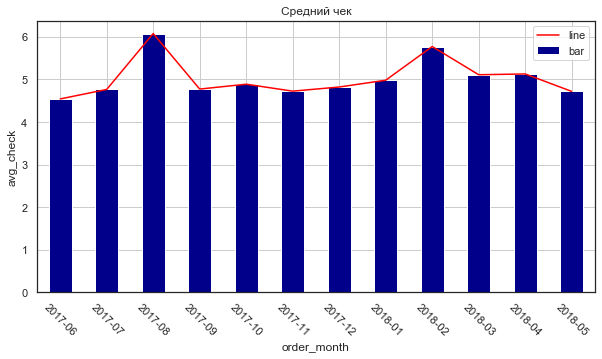

In [92]:
ax = avg_check.plot(
    x = 'order_month', y = 'avg_check', 
    color = 'red', grid = True, figsize = (10, 5))

avg_check.plot(
    x = 'order_month', y = 'avg_check', kind = 'bar',
    color = 'darkblue', grid = True, figsize = (10, 5), ax = ax)

plt.title('Средний чек')
plt.legend(['line', 'bar'])
plt.ylabel('avg_check')
plt.xticks(rotation = 315)
plt.show()

График показывает, что средний чек возрастает в декабре 2017, верятно, в связи с новогодними праздниками и показывает наибольшее падение в январе по той же причине.

[**Вернуться к оглавлению...**](#content)

## 3.4. Количество приносимых денег (LTV) <a name="step_3_4"></a>

Для каждого пользователя находим источник, из которого он впервые пришёл на сайт.

In [93]:
user_source = (
    visits
    .sort_values(by = ['uid', 'start_ts'])
    .groupby('uid')
    .agg({'source_id': 'first'})
    .reset_index())

Проводим над таблицей `orders_ltv` все необходимые настройки для дальнейшей работы.

In [94]:
orders_ltv = (
    orders[orders['order_date'] < '2018-06-01'].copy())

orders_ltv['order_date'] = pd.to_datetime(
    orders['order_date'].dt.date, format = '%Y-%m-%d')

orders_ltv['order_month'] = (
    orders['order_date'].astype('datetime64[M]'))

Для каждого пользователя получаем месяц перывой покупки.

In [95]:
first_order = (
    orders_ltv
    .groupby('uid')
    .agg({'order_month': 'min'})
    .reset_index()
    .rename(columns = {'order_month': 'first_order_month'}))

Соединим датафреймы `user_source` и `first_order_upd` и, в результате, определим, из какого источника пришёл пользователь, чтобы совершить свою первую покупку. Результат сохраним в переменной `first_order_with_source`.

In [96]:
first_order_with_source = first_order.merge(user_source, how = 'left', on = 'uid')

In [97]:
first_order_with_source

,uid,first_order_month,source_id
0,313578113262317,2017-12-01,2
1,1575281904278712,2018-02-01,10
2,2429014661409475,2017-07-01,3
3,2464366381792757,2018-05-01,5
4,2551852515556206,2018-04-01,5
...,...,...,...
36501,18445147675727495770,2018-03-01,5
36502,18445407535914413204,2017-08-01,3
36503,18445601152732270159,2018-03-01,2
36504,18446156210226471712,2018-03-01,3


Соеденими список заказов с датафреймом `first_order_with_source` и получим источник для каждого заказа.

In [98]:
orders_ltv = orders_ltv.merge(first_order_with_source, how = 'left', on = 'uid')
orders_ltv['first_order_month'] = pd.to_datetime(orders_ltv['first_order_month'], format = '%Y-%m-%d')

Посчитаем "время жизни" для каждой когорты, сформированной по принципу "оформил свой первый заказ в этом месяце".

In [99]:
orders_ltv['lifetime'] = (
    (orders_ltv['order_month'] - 
     orders_ltv['first_order_month']) /
    np.timedelta64(1, 'M')).round().astype('int64')

In [100]:
orders_ltv

,order_date,revenue,uid,order_month,first_order_month,source_id,lifetime
0,2017-12-20,17.00,10329302124590727494,2017-12-01,2017-12-01,1,0
1,2018-02-19,0.55,11627257723692907447,2018-02-01,2018-02-01,2,0
2,2017-07-01,0.37,17903680561304213844,2017-07-01,2017-07-01,2,0
3,2018-05-20,0.55,16109239769442553005,2018-05-01,2018-05-01,2,0
4,2017-12-27,0.37,14200605875248379450,2017-12-01,2017-12-01,3,0
...,...,...,...,...,...,...,...
50356,2017-06-04,4.64,12296626599487328624,2017-06-01,2017-06-01,4,0
50357,2017-10-10,5.80,11369640365507475976,2017-10-01,2017-10-01,10,0
50358,2018-04-14,0.30,1786462140797698849,2018-04-01,2018-04-01,3,0
50359,2017-10-16,3.67,3993697860786194247,2017-10-01,2017-10-01,3,0


Посчитаем суммарную выручку для каждого источника на каждом периоде жизни.

In [101]:
sum_revenue = orders_ltv.pivot_table(
    index = 'source_id',
    columns = 'lifetime',
    values = 'revenue',
    aggfunc = 'sum')

Просуммируем значения в строках таблицы, получив тем самым суммарную выручку за каждый месяц.

In [102]:
cumsum_revenue = sum_revenue.fillna(0).cumsum(axis = 1)

Выведем полученный результат на экран.

In [103]:
cumsum_revenue

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,13867.30,15353.65,16559.33,18486.59,20638.88,22893.73,24963.11,26449.62,27965.69,29495.56,30457.49,31086.27
2,17472.45,18837.29,22858.23,25083.98,27404.58,29690.86,33316.97,36894.38,40161.35,43439.34,44488.27,46923.61
3,42185.13,44000.69,45493.47,47435.30,49314.82,50407.62,51600.11,52482.17,53389.94,53923.83,54299.24,54506.35
4,42419.73,44057.31,45905.32,47988.04,49562.77,51354.67,52417.08,53778.25,55076.66,55866.51,56371.07,56696.83
5,30107.54,31533.19,33401.82,35087.46,37678.22,40497.56,42457.61,43709.41,48437.05,49487.70,52069.28,52621.88
7,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22
9,3710.92,4140.19,4367.73,4696.56,4925.57,5112.39,5334.22,5505.44,5588.46,5657.65,5735.24,5759.40
10,3747.78,3892.14,3981.65,4080.62,4193.83,4269.45,4342.48,4415.28,4432.62,4440.86,4443.55,4450.33


Найдём количество уникальных пользователей в каждом источнике за весь исследуемый период.

In [104]:
cohort_sizes = (
    first_order_with_source
    .groupby('source_id')
    .agg({'uid': 'nunique'})
    .rename(columns = {'uid': 'cohort_size'}))

In [105]:
cohort_sizes

,cohort_size
source_id,
1,2895
2,3503
3,10466
4,10296
5,6930
7,1
9,1088
10,1327


Соеденим таблицы `cumsum_revenue` и `cohort_sizes`.

In [106]:
cumsum_revenue = cumsum_revenue.merge(
    cohort_sizes, how = 'left', on = 'source_id')

Посчитаем `ltv` (пожизенная ценность клиента) разделив суммарную в каждом месяце на общее количество уникальных пользователей за весь период для каждого источника.

In [107]:
ltv = (
    cumsum_revenue
    .div(cumsum_revenue['cohort_size'], axis = 0)
    .drop(columns = 'cohort_size'))

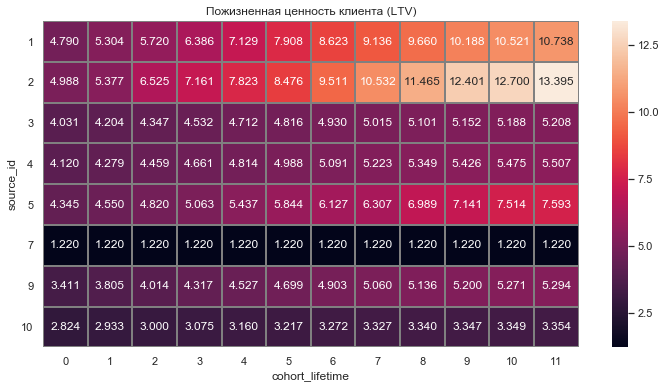

In [108]:
plt.figure(figsize = (12, 6))
yticks = ltv.index
sns.heatmap(ltv, annot = True, fmt = '.3f', linewidths = 1,
            yticklabels = yticks, linecolor = 'gray')
plt.title('Пожизненная ценность клиента (LTV)')
plt.xlabel('cohort_lifetime')
plt.yticks(rotation = 0)
plt.show()

[**Вернуться к оглавлению...**](#content)

## Шаг 3. Вывод (продажи) <a name="step_3_end"></a>

**1.** В какой момент пользователи начинают покупать?

* Из графика, представленного в расчётах, видно, что в среднем, в зависимости от периода, проходит от 2 до 5 часов с момента первого посещения пользователем сервиса до его первой покупки. Кроме того, стоит отметить положительную динамику к снижению времени, проходящего с момента первого посещения до первой покупки. Пользователи в 2018 году начинают покупать быстрее. Это хороший знак.

**2.** Количество покупок.

* По графику зависимости количества покупок от месяца можно сделать вывод, что общее количество покупок возрастает в ноябре и декабре. Вероятно, в предверии новогодних праздников. И показатель общего количества покупко в первые месяцы 2018 года в среднем выше, чем в конце 2017. Этот факт говорит о положительной динамике.

**3.** Средний чек.

* График показывает, что средний чек возрастает в декабре 2017, верятно, в связи с новогодними праздниками и показывает наибольшее падение в январе, вероятно, по той же причине.

**4.** Пожизненная ценность клиента (LTV).

Исходя из сводной таблицы, где для каждого источника для каждогого месяца жизни посчитана накопительная выручка видно, что у источника номер 7 нет никакой положительной динамики исовершена одна единственная покупка на втором месяце жизни. Можно сделать предположение, что это техническая ошибка. И, на самом деле, пользователь, пришёл из какого-то друого источника.

[**Вернуться к оглавлению...**](#content)

# Шаг 4. Маркетинг. Расчёт метрик <a name="step_4"></a>

## 4.1. Расчёт метрик CAC и ROI <a name="step_4_1"></a>

Посчитаем общие затраты на каждый из источников.

In [109]:
costs_per_source = costs.groupby('source_id')['costs'].sum().reset_index()

Добавим параметр `colors` для удобства построения графиков. Чтобы за каждым источником был закреплён свой собственный цвет.

In [110]:
costs_per_source['colors'] = (
    pd.Series(['red', 'green', 'blue',
               'darkcyan', 'orange', 'black', 'dodgerblue']))

Создадим датафрейм `cac`, образованный в результате соединения датафреймов `costs_per_source` и `ltv`.

In [111]:
cac = costs_per_source.merge(cohort_sizes, how = 'left', on = 'source_id')

Посчитаем метрику `cac` (стоимость привлечения клиента) для пользователей всех источников.

In [112]:
cac['cac'] = cac['costs'] / cac['cohort_size']

In [113]:
cac = cac.set_index('source_id')

Выведем полученный результат на экран.

In [114]:
cac_plot = cac.sort_values(by = 'cac', ascending = False).reset_index()

In [115]:
cac_plot

,source_id,costs,colors,cohort_size,cac
0,3,141321.63,blue,10466,13.502927
1,2,42806.04,green,3503,12.219823
2,5,51757.10,orange,6930,7.468557
3,1,20833.27,red,2895,7.196294
4,4,61073.60,darkcyan,10296,5.931779
5,9,5517.49,black,1088,5.071222
6,10,5822.49,dodgerblue,1327,4.387709


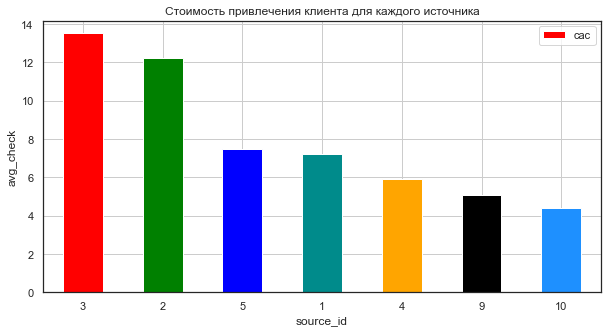

In [116]:
cac_plot.plot(x = 'source_id', y = 'cac', kind = 'bar', 
              grid = True, color = cac['colors'].values, figsize = (10, 5))

plt.title('Стоимость привлечения клиента для каждого источника')
plt.ylabel('avg_check')
plt.xticks(rotation = 0)
plt.show()

Дороже всего обходится клиент, приходящий из иссточника № 3, в то время как, самым дешёвым, с точки зрения привлечения, клиентом является клиент, впервые пришедший из источника № 10.

Оценим качество вложений в маркетинговую кампанию и расчитаем метрику `romi`.

In [117]:
romi = ltv.merge(cac['cac'], how = 'inner', on = 'source_id')
romi = romi.div(romi['cac'], axis = 0).drop(columns = 'cac')

Выведем полученную сводную таблицу `romi` на экран в виде тепловой карты.

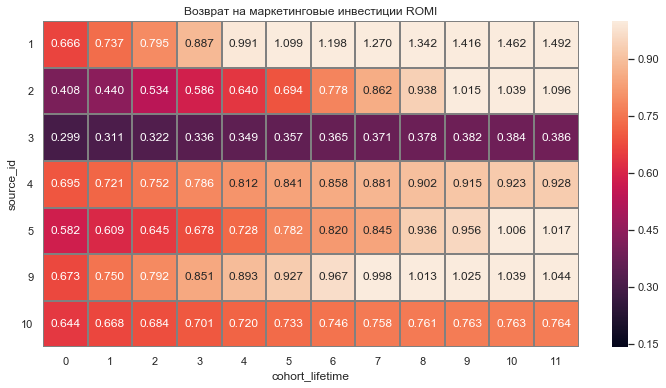

In [118]:
plt.figure(figsize=(12, 6))
yticks = romi.index
sns.heatmap(romi, annot = True, fmt = '.3f', linewidths = 1,
            yticklabels = yticks, linecolor = 'gray', vmax = 1, vmin = 0.14)
plt.title('Возврат на маркетинговые инвестиции ROMI')
plt.xlabel('cohort_lifetime')
plt.yticks(rotation = 0)
plt.show()

[**Вернуться к оглавлению...**](#content)

## 4.2. Сколько денег потратили? <a name="step_4_2"></a>

Найдём сколько денег потратила Афиша на все рекламные кампании за весь период.

In [119]:
print('Суммарные затраты: {}'.format(costs['costs'].sum()))

Суммарные затраты: 329131.62


Отобразим суммарные затраты по источникам на графике.

In [120]:
costs_per_source = (
    costs_per_source
    .sort_values(by = 'costs', ascending = False)
    .reset_index(drop = True))

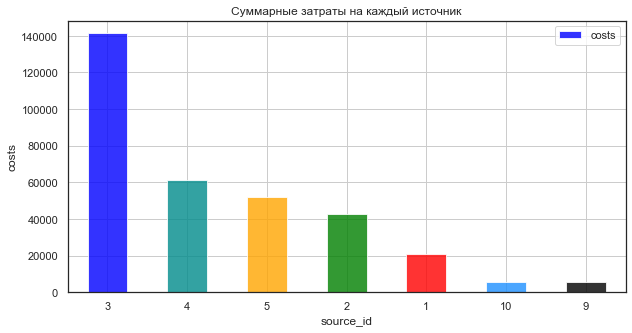

In [121]:
costs_per_source.plot(
    x = 'source_id', y = 'costs',
    kind = 'bar', grid = True, figsize = (10, 5),
    color = costs_per_source['colors'].values, alpha = 0.8)

plt.title('Суммарные затраты на каждый источник')
plt.ylabel('costs')
plt.xticks(rotation = 0)
plt.show()

Наибольшее зартраты приходятся на 3-й источник, в то время как он демонстрирует плохую окупаемость.

In [122]:
costs['month'] = costs['date'].astype('datetime64[M]').dt.strftime('%Y-%m')

In [123]:
costs_per_month = (
    costs
    .groupby(['month', 'source_id'])
    .agg({'costs': 'sum'}))

In [124]:
costs_per_month.head()

costs
month   source_id         
2017-06 1          1125.61
        2          2427.38
        3          7731.65
        4          3514.80
        5          2616.12

In [125]:
costs_per_source = (
    costs_per_source
    .sort_values(by = 'source_id')
    .reset_index(drop = True))

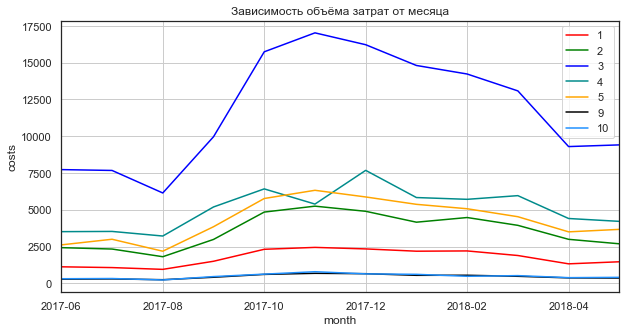

In [126]:
costs_per_month.unstack().plot(
    grid = True, figsize = (10, 5),
    color = costs_per_source['colors'].values)

plt.legend(costs_per_source['source_id'].unique())
plt.title('Зависимость объёма затрат от месяца')
plt.ylabel('costs')
plt.show()

Прослеживается тенденция, что затраты на рекламные кампании возрастают к новогодним праздникам, начинают спадать в январе и выравниваются к апрелю 2018.

[**Вернуться к оглавлению...**](#content)

# Шаг 5. Рекомендации меркетологам <a name="step_5"></a>

**Источник №1**

* На тепловой карте мы видим, что источник под номером 1 практически окупился уже за первые 2 месяца, но окончательно достиг окупаемости на 3 месяц. Стоит увееличить вложения для привлечения большего количества клиентов.

**Источник №2**

* Источник под номером 2 окупился на 5 месяц и демонстрирует полжительную динамику. В этот источник можно смело продолжать делать вложения, так как он демонстрирует свою окупаемость и потенциально может оказаться эффективным с точки зрения получения прибыли.

**Источники №5, 9**

* Источники 5 и 9 окупились на 8 и 7 месяц соответственно. Вероятно, с увеличением вложений, они могут начать приводить больше клиентов готовых оформить заказ.

**Источник №3**

* Источник номер 3 как при самых больших суммарных затратах, так и при наибольших затратах на привлечение одного клиента показал себя самым худшим образом. От вложений в этот источник я бы рекомендовал отказаться.


**Источник №4, 10**

* Источникам 4 и 10 не удалось окупиться за год. Это плохо, вероятно, от вложений следует отказаться и сконцентрироваться на более успешных источниках.

[**Вернуться к оглавлению...**](#content)

# Шаг 6. Общий вывод <a name="step_6"></a>

**Шаг 1. Изучение входных данных**

**1.1. Изучение входных данных:**

* Датасеты `visits.csv`, `orders.csv`, `costs.csv` были прочитаны при помощи метода `read_csv()`.


* Пропущенные значения, в исследуемых датафреймах `visits`, `orders`, `costs`, не были обнаружены.



* Типы данных во всех датафреймах были проверены на соответствие. В результате проверки было обнаружено, что некоторые параметры, хранящие в себе информацию о датах имели тип данных `object`. 



* В наименованиях некоторых параметров были обнаружены пробелы.

**1.2. Подготовка данных к анализу:**

В ходе предобробатки в данных были проивзедены следующие изменения:

* Пробелы в наименованиях параметров были заменены на нижнее подчёркивание `_`.


* Наименования параметров были приведены к нижнему регистру.


* Наименование параметра `dt` датафрейма `costs` было изменено на `date`.



* Параметры `ens_ts` и `start_ts` датафрейма `visits`, параметр `buy_ts` датафрейма `orders` и параметр `date` датафрейма `costs` были приведены к типу данных `datetime64`.


* В датафрейме `visits` были удалены аномалии, где время дата и время начала сесии были больше даты и времени её окончания.


* Из датафрейма `orders` были удалены строки в которых значения параметра `revenue` были равны нулю.

**1.** Для продукта была проведена оценка пользовательской активности. В результате были посчитаны следующие метрики:
    
 
* **DAU** = 907;
    
 
* **WAU** = 5716;
    
 
* **MAU** = 23228;
    

* **Sticky factor (WAU)** = 15.87;
    
 
* **Sticky factor (MAU)** = 3.90
   
Кроме того, был построен графики, сравнивающие метрики **dau**, **wau**, **mau** на двух разных типах устройств. График показал, что пользователей, использующих тип устройства `desktop` ежедневно/еженедельно/ежемесячно приходит больше, чем пользователей, использующих `touch`.

Также стоит отметить, что на графике **dau** присутствуют два аномальных значения по количеству пришеддших пользователей. Два аномальных паплыва приходятся на 24 ноября 2017 и 31 мая 2018. Возможно, в этот на сервисе проводилась акция или розыгрыш билетов.

**2.** Пользовательская сессия


* Следующим шагом в изучения продукта была оценка пользовательской сессии. Первым делом был произведён подсчёт количества сессий в месяц и в день, в среднем приходящееся на одного пользователя. Результаты расчёта равны **1.28 сессий на одного пользователя**. Это значит, что пользователи не посещают сервис более одного раза в месяц. 


* Средняя продолжительность сессии **ASL** равна **1-й минуте**. Кроме того, продолжительности пользовательских сессий на разных типах устройств имеют статистические различия. Пользователи, использующие тип устройств `desktop` в среднем проводят больше времени за сессию. Можно сделать предположение, что сайт или приложение в мобильной версии отображаются некорректно или имеют прочие технические ошибки. Стоит это проверить.

**3.** Retantion Rate и Churn Rate. Были построеные две тепловые карты для вышеупомянутых метрик. Тепловая карта метрики Churn Rate показала, что большой отток пользователей происходит на 2 месяце жизни когорты. Возможно, на этом этапе у пользователей возникают сложности с взаимодействием с продуктом или они уходят по каким-то другим причинам. 

**Шаг 3. Продажи. Расчёт метрик**

**1.** В какой момент пользователи начинают покупать?

* Из графика, представленного в расчётах, видно, что в среднем, в зависимости от периода, проходит от 2 до 5 часов с момента первого посещения пользователем сервиса до его первой покупки. Кроме того, стоит отметить положительную динамику к снижению времени, проходящего с момента первого посещения до первой покупки. Пользователи в 2018 году начинают покупать быстрее. Это хороший знак.

**2.** Количество покупок.

* По графику зависимости количества покупок от месяца можно сделать вывод, что общее количество покупок возрастает в ноябре и декабре. Вероятно, в предверии новогодних праздников. И показатель общего количества покупко в первые месяцы 2018 года в среднем выше, чем в конце 2017. Этот факт говорит о положительной динамике.

**3.** Средний чек.

* График показывает, что средний чек возрастает в декабре 2017, верятно, в связи с новогодними праздниками и показывает наибольшее падение в январе, вероятно, по той же причине.

**4.** Пожизненная ценность клиента (LTV).

Исходя из сводной таблицы, где для каждого источника для каждогого месяца жизни посчитана накопительная выручка видно, что у источника номер 7 нет никакой положительной динамики исовершена одна единственная покупка на втором месяце жизни. Можно сделать предположение, что это техническая ошибка. И, на самом деле, пользователь, пришёл из какого-то друого источника.

**Шаг 4,5. Рекомендации маркетологам**

**Источник №1**

* На тепловой карте мы видим, что источник под номером 1 практически окупился уже за первые 2 месяца, но окончательно достиг окупаемости на 3 месяц. Стоит увееличить вложения для привлечения большего количества клиентов.

**Источник №2**

* Источник под номером 2 окупился на 5 месяц и демонстрирует полжительную динамику. В этот источник можно смело продолжать делать вложения, так как он демонстрирует свою окупаемость и потенциально может оказаться эффективным с точки зрения получения прибыли.

**Источники №5, 9**

* Источники 5 и 9 окупились на 8 и 7 месяц соответственно. Вероятно, с увеличением вложений, они могут начать приводить больше клиентов готовых оформить заказ.

**Источник №3**

* Источник номер 3 как при самых больших суммарных затратах, так и при наибольших затратах на привлечение одного клиента показал себя самым худшим образом. От вложений в этот источник я бы рекомендовал отказаться.


**Источник №4, 10**

* Источникам 4 и 10 не удалось окупиться за год. Это плохо, вероятно, от вложений следует отказаться и сконцентрироваться на более успешных источниках.

[**Вернуться к оглавлению...**](#content)